In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, cmath
from scipy.integrate import odeint
import pandas as pd

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from concurrent.futures import ThreadPoolExecutor
from qiskit import transpile
from qiskit.circuit.library import UnitaryGate, HamiltonianGate

def rho_dot(rho, t, args, C):
    """
    Computes the time derivative of the density matrix
    coefficients in terms of the structure constants C
    of the base. This function implements Eq. (61).

    Output
    rho_dot: numpy array containing the elements of
        the time derivative of the density matrix
        coefficients in terms of the structure constants
        Q of the base

    Time derivative of the density matrix coefficients in
    terms of the structure constants Q of the base

    Parameters
    rho: vector (list or numpy array) containing the elements
        of the density matrix.
    t: time variable
    args: list containing the Hamiltonian parameters.
    C: numpy array containing the structure constants
        of the base.

    """
    a = ham_coefs(t, args)
    mat = np.transpose(np.tensordot(a, C, axes = ([0],[0])))
    rho_dot = np.matmul(mat, rho)

    return rho_dot

def classical_sol(dt, tdiv, rho0, args, C):
    """Obtains the classical solution for the coefficients of the
    density matrix numerically solving the time dependent
    von Neumann equation following the procedure outlined
    in the Supplemental Material.

    Output
    np.array(t_list): numpy array with the list of times used in the
        classical simulation.
    np.array(probs_list): numpy array with the list of probabilieties
        of the classical simulation corresponding to t_list.
    np.array(rho_list): numpy array with the list of density matrix
        coefficients corresponding to t_list.

    Parameters
    tmin: initial time in the classical simulation.
    tmax: final time in the classical simulation.
    tdiv: time divisions in the classical simulation.
    rho0: initial coefficients of the density matrix.
    args: list of the Hamiltonian arguments.
    C: numpy array containing the structure constants
        of the base.
    """

    #odeint

    probs_list = []
    rho_list = []
    t_list = []

    for k in range(tdiv):
        t = k * dt
        t_list.append(t)

    rhos = odeint(rho_dot, rho0, t_list, args=(args,C))

    for rho in rhos:
        probs = [amp ** 2 for amp in rho]
        probs_list.append(probs)
        rho_list.append(rho)

    return np.array(t_list), np.array(probs_list), np.array(rho_list)

def list_states(nq):
    """Lists the possible states in binary format of a
    register with nq qubits.

    Output
    states: list of strings in binary format containing the list
        of all possible states.

    Parameters
    nq: integer of the number of qubits.

    """
    states = []
    for k in range(2 ** nq):
        kbin = bin(k)[2:]
        while len(kbin) < nq:
            kbin = '0' + kbin
        states.append(kbin)

    return states

def Ui_gate(rho0, nq):
    """Calculates the U_i gate that initializes the second
    register to the density matrix elements.
    This function implements the initialization of
    the quantum circuit given by Eq. (67).

    Ouptut
    qc.to_gate(): Qiskit gate of the initialization unitary
        Householder matrix.

    Parameters
    rho0: initial coefficients of the density matrix.
    nq: integer number of the number of qubits.

    """

    dim = 2**(nq - 1)

    u = np.zeros(dim)
    u[0] = 1.0

    r0 = rho0 / np.sqrt(np.dot(rho0, rho0))

    w = np.array([r0 - u])

    #Householder matrix
    H = np.identity(dim) - np.matmul(np.transpose(w), w) / (1.0 - r0[0])

    qcH = QuantumCircuit(nq - 1)
    qcH.append(UnitaryGate(H), range(nq - 2, -1, -1))
    UH = qcH.to_gate(label='$U_H$').control(1)

    qc = QuantumCircuit(nq)

    qc.h(nq - 1)
    qc.append(UH, range(nq - 1, -1, -1))
    qc.x(nq - 1)

    for jj in range(nq - 1):
        qc.ch(nq - 1, jj)

    qc.x(nq - 1)

    return qc.to_gate(label='$U_I$')

def Evol_gate(alpha, nq, C):
    """Composes the Evol gate through a HamiltonianGate.
    This function implements the gate M in Fig. 1 (c)
    or Eq. (7)
    
    Output
    qEvol.to_gate(): gate of the M transformation
    
    Parameters
    alpha: numpy array containing the parameters of
        the M unitary transformation.
    nq: integer number of the number of qbits.
    C: numpy array containing the structure
      constants.
    """

    dim = np.shape(C)[0]

    H = 1j * np.tensordot(alpha, C, axes = ([0, ],[0, ]))
    
    qEvol = QuantumCircuit(nq - 1)
    Hg = HamiltonianGate(H, 1.0)
    qEvol.append(Hg, range(nq - 2, -1 , -1))
    
    return qEvol.to_gate(label='qEvol')

def qcircuit_nh(dt, n, rho0, args, nq, C):
    """Builds the quantum circuit for n time steps of the
    M gate. This function implements the quantum circuit
    shown in Fig. 1 (a).
    
    Output
    qcc: Qiskit QuantumCircuit containing a circuit of n
        time steps
        
    Parameters
    dt: real number of the size of the time step.
    n: integer number of time steps.
    rho0: initial coefficients of the density matrix.
    args: list of the Hamiltonian arguments.
    nq: integer number of the number of qbits.
    C: numpy array containing the swapped structure
        constants.
    """
    
    qc = QuantumCircuit(nq - 1, name='$M({\\bf \\alpha})$')
    qcc = QuantumCircuit(nq, nq)
    Ui = Ui_gate(rho0, nq)
    qcc.append(Ui, range(nq))
    
    for k in range(n):
        dt_a = dt * ham_coefs(k * dt, args)

        qEvol = Evol_gate(dt_a, nq, C)

        qc.append(qEvol, range(nq - 1))
    
    #build controlled Evol gate 
    cEvol_gate = qc.to_gate().control(1)

    qcc.append(cEvol_gate,  range(nq - 1, -1, -1))
    
    qcc.h(nq - 1)

    qcc.barrier(range(nq))

    qcc.measure(range(nq), range(nq))
    
    return qcc

def pauli_base(nq):
    """Generates all the elements of an algebra given by
    (1/2)^{n/2}\sigma_{i_1} \otimes \sigma_{i_2} \otimes
    ... \sigma_{i_n} using Eq. (B1) iteratively where
    \sigma_0 is the 2 x 2 identity matrix and \sigma_1,
    \sigma_2 and \sigma_3 are the Pauli matrices

    Output
    base_1: numpy array containing all the elements of
        the matrix base.

    Parameters
    nq: integer with the number of qubits.

    """
    base_0 = np.array([
        (1.0/np.sqrt(2.0) + 0j) * np.identity(2),
        (1.0/np.sqrt(2.0) + 0j) * np.array([[0, 1], [1, 0]]),
        (1.0/np.sqrt(2.0) + 0j) * np.array([[0, -1j], [1j, 0]]),
        (1.0/np.sqrt(2.0) + 0j) * np.array([[1, 0], [0, -1]])
    ])

    base_1 = base_0[:]

    for k in range(nq - 1):
        base_2 = []
        for el1 in base_1:
            for el0 in base_0:
                base_2.append(np.kron(el1, el0))
        base_1 = np.array(base_2)

    return base_1

def simple_base(nq):
    """Generates all the elements of an algebra given by
    s_{i_1} \otimes s_{i_2} \otimes \dots \s_{i_n}
    
    Output
    base_1: numpy array containing all the elements of
        the matrix base.
    
    Parameters
    nq: integer with the number of qbits.
    
    """
    dim = 2 ** nq
    base = []
    for ii in range(dim):
        for jj in range(dim):
            q = 0j * np.zeros((dim, dim))
            q[jj, ii] = 1 + 0j
            base.append(q)
    
    return base

def structure_constants_base(base):
    """Calculates the structure constants of base.
    This function implements Eq. (2).
    
    Output
    C: numpy array containing the structure constants
        of base.
        
    Parameters
    base: numpy array containing all the elements of
        the matrix base.
    
    """
    dim = np.shape(base)[0]
    C = 0j * np.zeros((dim, dim, dim))
    for k0, el0 in enumerate(base):
        for k1, el1 in enumerate(base):
            commu = np.matmul(el0, el1) - np.matmul(el1, el0) 
            for k2, el2 in enumerate(base):
                C[k0, k1, k2] = (-1j * np.trace(np.matmul(commu, el2.conjugate().transpose())) 
                                / np.trace(np.matmul(el2, el2.conjugate().transpose())))
                
    return C

#############################################
# EXAMPLE 1                                 #
# One spin 1/2 particle                     #
# subject to an oscillating magnetic field  #
# in the base q_n   (simple base)           #
#############################################

def ham_coefs(t, args):
    """Calculates the coefficients for the nuclear
    resonance Hamiltonian of a spin 1/2 particle
    in the Pauli base.
    
    Output
    a: numpy array containing the Hamiltonian coefficients
    
    Parameters
    t: time variable.
    args: Hamiltonian arguments.
        omega: Angular frequency of the electromagnetic
            drive.
        omega0: energy separation of the two level
            system.
        omega1: Rabi frequency
    
    """

    
    dim, omega0, omega1, omega, phi = args
    a = np.zeros(dim)
    a[1] = omega1 * np.cos(omega * t) / np.sqrt(2.0)
    a[2] = -omega1 * np.cos(omega * t + phi) / np.sqrt(2.0)
    a[3] = -omega0 / np.sqrt(2.0)
    
    return a

# Calculation of the structure constants
# of the Pauli and the simple base
# from the q algebra

print('base and structure constants')
dim = 4
nq = 3

base_pa = pauli_base(1)
C_pa = np.real(structure_constants_base(base_pa))

base_si = simple_base(1)
C_si = structure_constants_base(base_si)

# Values of the
# Hamiltonian parameters
# Values of the
# Hamiltonian parameters

omega0 = 1.0
omega1 = 22.0
omega = 0.90
phi = np.pi/2

tmin = 0.0
tmax = 2 * np.pi/omega1

args = (dim, omega0, omega1, omega, phi)

# Initial conditions of the 
# density matrix coefficients
# expressed in terms of base

rho0 = [1/np.sqrt(2), 0.0, 0.0, -1/np.sqrt(2)]

# Classical algorithm solution in the Pauli base
tdiv = 500

dt = (tmax - tmin) / tdiv

print('classical solution')
t_list_od, probs_list_od, rho_list_od = classical_sol(dt,
                                                      tdiv, rho0, args, C_pa)

# Transform the classical solution from the Pauli base
# to the simple base
T = np.array([[np.trace(np.matmul(bsi.transpose().conjugate(), bpa))
              for bsi in base_si]
              for bpa in base_pa])

rho_list = []
for rhopa in rho_list_od:
    rhosi = np.matmul(T, rhopa)
    rho_list.append(rhosi)
rho_list_od = np.array(rho_list)

# Create a DataFrame for the classical
# solution and save it
print('saving classical results')
df_od = pd.DataFrame(np.transpose(np.append([t_list_od], np.transpose(rho_list_od), axis=0)))
df_od.to_csv('Results/example-1-nh/results_od.csv')

# Setting the parameters
# for the quantum gates
print(' ')
print('quantum solution')

def ham_coefs(t, args):
    """Calculates the coefficients for the nuclear
    resonance Hamiltonian of a spin 1/2 particle
    in the simple base.
    
    Output
    a: numpy array containing the Hamiltonian coefficients
    
    Parameters
    t: time variable.
    args: Hamiltonian arguments.
        omega: Angular frequency of the electromagnetic
            drive.
        omega0: energy separation of the two level
            system.
        omega1: Rabi frequency
    
    """

    dim, omega0, omega1, omega, phi = args
    a1 = omega1 * np.cos(omega * t) / 2.0
    a2 = omega1 * np.cos(omega * t + phi) / 2.0
    a3 = omega0 / 2.0
    a = 0j * np.zeros(dim)
    a[0] = - a3
    a[1] = a1 - 1j * a2 
    a[2] = a1 + 1j * a2
    a[3] = a3
    
    return a

# Initial conditions of the 
# density matrix coefficients
# expressed in terms of the simple base
# base_si for the quantum algorithm

rho0 = [0.0, 0.0, 0.0, 1.0]

# Set backend
print('creating backend')
backend = AerSimulator()
exc = ThreadPoolExecutor(max_workers=20)
backend.set_options(executor=exc)
backend.set_options(max_job_size=1)

states = list_states(nq - 1)
n0 = np.sqrt(np.dot(rho0, rho0))

t_list_qg = []
rho_list_qg = []
max_div = 50
ndat = 1
for tdiv in range(1, max_div + 1):

    print('*****************************')
    print(tdiv, '/', max_div)
    tmin = 0.0
    tmax = tdiv / max_div * 2 * np.pi / omega1

    dt = (tmax - tmin) / tdiv

    # Build and transpile quantum circuits for the whole run
    # using the qasm simulator

    print('generating quantum circuit')
    qc = qcircuit_nh(dt, tdiv, rho0, args, nq, C_si)

    # Transpile circuits
    print('transpiling circuit')
    tran_qc = transpile(qc, backend=backend)
    shots = 2048 * 8

    # Run the quantum circuit and retrieve results
    print('runing circuit')
    result = backend.run(tran_qc, shots=shots).result()

    # Quantum tomography
    # Calculate the list of probabilities
    # and the list of the density matrix
    # coeficients of a non-hermitian base

    error = False
    rho = []
    count = result.get_counts()
    for state in states:
        p0 = count.get('0' + state, 0) / shots
        p1 = count.get('1' + state, 0) / shots
        absrho2 = 2 * (p0 + p1) - 1 / 2**(nq - 1)
        if absrho2 > 0:
            absrho = np.sqrt(absrho2)
            rerho = np.sqrt(2**(nq - 1)) * (p0 - p1)
            if rerho**2 <= absrho2:
                imrho = np.sqrt(absrho2 - rerho**2)
                rho.append(n0 * (rerho + 1j * imrho))
            else:
                error = True
        else:
            error = True
        
    if not error:
        rho_list_qg.append(rho)
        t_list_qg.append(tdiv * dt)

    if error:
        print('some of the conditions failed')
        
rho_list_qg = np.array(rho_list_qg)

base and structure constants
classical solution
saving classical results
 
quantum solution
creating backend
*****************************
1 / 50
generating quantum circuit
transpiling circuit
runing circuit
some of the conditions failed
saving quantum solution
*****************************
2 / 50
generating quantum circuit
transpiling circuit
runing circuit
some of the conditions failed
saving quantum solution
*****************************
3 / 50
generating quantum circuit
transpiling circuit
runing circuit
some of the conditions failed
saving quantum solution
*****************************
4 / 50
generating quantum circuit
transpiling circuit
runing circuit
some of the conditions failed
saving quantum solution
*****************************
5 / 50
generating quantum circuit
transpiling circuit
runing circuit
saving quantum solution
*****************************
6 / 50
generating quantum circuit
transpiling circuit
runing circuit
some of the conditions failed
saving quantum solution
***

In [21]:
# Fix quantum results
rho_list_qg_fixed = 0j * np.zeros(np.shape(rho_list_qg))

for j in range(np.shape(rho_list_qg)[0]):
    for state in system_states:
        k = int(state, 2)
        if t_list_qg[j] < np.pi / 22.0:
            if k == 1:
                # Fixes de phase of rho_2
                rho_list_qg_fixed[j, k] =  -1j * rho_list_qg[j, k]
            elif k == 2:
                # Fixes the sign of rho_3 if time < pi/omega_1
                rho_list_qg_fixed[j, k] =  - rho_list_qg[j, k]
            else:
                # rho_0 and rho_4 remain unchanged
                rho_list_qg_fixed[j, k] =  rho_list_qg[j, k]
        else:
            if k == 1:
                # Fixes the phase of rho_2
                rho_list_qg_fixed[j, k] =  1j * rho_list_qg[j, k]
            else:
                #
                rho_list_qg_fixed[j, k] =  rho_list_qg[j, k]

            
        

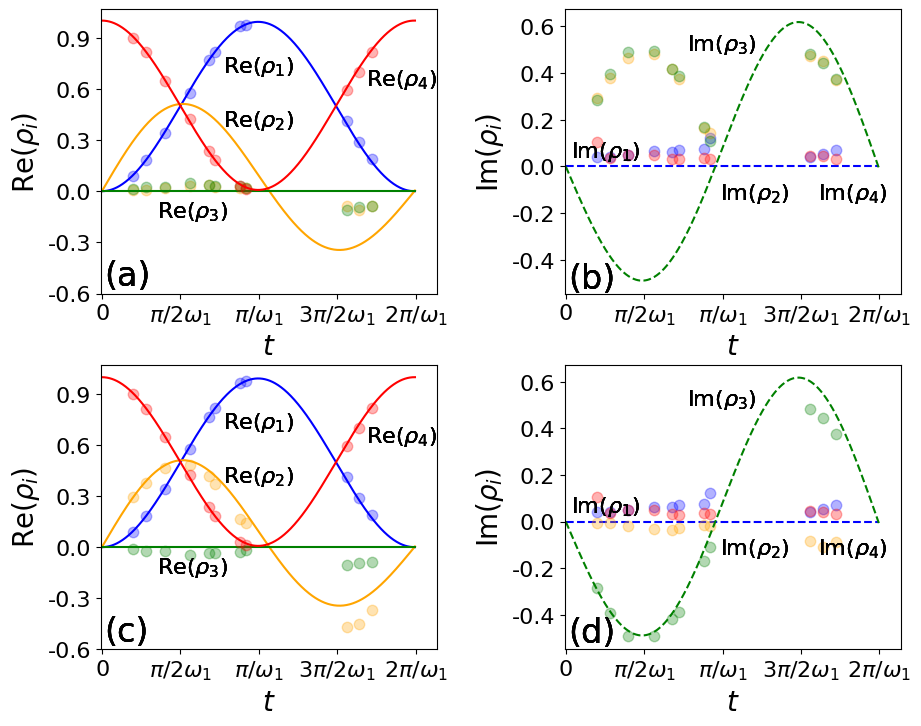

In [23]:
# Plot the density matrix coefficients
# from the classical and quantum
# simulations.
# The continuous lines are the classical
# simulation and the dots correspond
# to the quantum simulation.
colors = ['blue', 'orange', 'green', 'red']
y_limsa = [-0.6, -0.3, 0.0, 0.3, 0.6, 0.9]
y_limsb = [-0.4, -0.2, 0.0, 0.2, 0.4, 0.6]

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2,2, hspace=0.25, wspace=0.38)
ax = gs.subplots()

system_states = list_states(nq - 1)

for state in system_states:
    k = int(state, 2)
    
    ax[0, 0].plot(t_list_od, np.real(rho_list_od[:, k]), color = colors[k])
    ax[0, 0].plot(t_list_qg, np.real(rho_list_qg[:, k]), '.', alpha = 0.3, markersize = 15, color = colors[k])
    ax[0, 0].set_xlim([-0.001,0.305])
    ax[0, 0].set_xlabel('$t$', fontsize=20)
    ax[0, 0].set_ylabel('$\\mathrm{Re}(\\rho_i )$', fontsize=20)
    ax[0, 0].set_xticks([2 * np.pi / 22.0 * ii/4 for ii in range(0, 5)])
    ax[0, 0].set_xticklabels(['$0$', '$\\pi/2\omega_1$', '$\\pi/\omega_1$', '$3\\pi/2\omega_1$', '$2\\pi/\omega_1$'],
                   fontsize = 16)
    ax[0, 0].set_yticks(y_limsa)
    ax[0, 0].set_yticklabels(y_limsa, fontsize=16)
    ax[0, 0].text(0.002, -0.55, '(a)', size=24)
    ax[0, 0].text(0.110,  0.70, '$\\mathrm{Re}(\\rho_1 )$', size=16)
    ax[0, 0].text(0.110,  0.38, '$\\mathrm{Re}(\\rho_2 )$', size=16)
    ax[0, 0].text(0.050, -0.15, '$\\mathrm{Re}(\\rho_3 )$', size=16)
    ax[0, 0].text(0.240,  0.62, '$\\mathrm{Re}(\\rho_4 )$', size=16)

    if k == 0 or k == 2:
        ax[0, 1].plot(t_list_od, np.imag(rho_list_od[:, k]), color = colors[k], linestyle = 'dashed')
    
    ax[0, 1].plot(t_list_qg, np.imag(rho_list_qg[:, k]), '.', alpha = 0.3, markersize = 15, color = colors[k])
    ax[0, 1].set_xlim([-0.001,0.305])
    ax[0, 1].set_xlabel('$t$', fontsize=20)
    ax[0, 1].set_ylabel('$\\mathrm{Im}(\\rho_i )$', fontsize=20)
    ax[0, 1].set_xticks([2 * np.pi / 22.0 * ii/4 for ii in range(0, 5)])
    ax[0, 1].set_xticklabels(['$0$', '$\\pi/2\omega_1$', '$\\pi/\omega_1$', '$3\\pi/2\omega_1$', '$2\\pi/\omega_1$'],
                   fontsize = 16)
    ax[0, 1].set_yticks(y_limsb)
    ax[0, 1].set_yticklabels(y_limsb, fontsize=16)
    ax[0, 1].text(0.002, -0.52, '(b)', size=24)
    ax[0, 1].text(0.110,  0.50, '$\\mathrm{Im}(\\rho_3 )$', size=16)
    ax[0, 1].text(0.005,  0.04, '$\\mathrm{Im}(\\rho_1 )$', size=16)
    ax[0, 1].text(0.140, -0.14, '$\\mathrm{Im}(\\rho_2 )$', size=16)
    ax[0, 1].text(0.230, -0.14, '$\\mathrm{Im}(\\rho_4 )$', size=16)


    ax[1, 0].plot(t_list_od, np.real(rho_list_od[:, k]), color = colors[k])
    ax[1, 0].plot(t_list_qg, np.real(rho_list_qg_fixed[:, k]), '.', alpha = 0.3, markersize = 15, color = colors[k])
    
    ax[1, 0].set_xlim([-0.001,0.305])
    ax[1, 0].set_xlabel('$t$', fontsize=20)
    ax[1, 0].set_ylabel('$\\mathrm{Re}(\\rho_i )$', fontsize=20)
    ax[1, 0].set_xticks([2 * np.pi / 22.0 * ii/4 for ii in range(0, 5)])
    ax[1, 0].set_xticklabels(['$0$', '$\\pi/2\omega_1$', '$\\pi/\omega_1$', '$3\\pi/2\omega_1$', '$2\\pi/\omega_1$'],
                   fontsize = 16)
    ax[1, 0].set_yticks(y_limsa)
    ax[1, 0].set_yticklabels(y_limsa, fontsize=16)
    ax[1, 0].text(0.002, -0.55, '(c)', size=24)
    ax[1, 0].text(0.110,  0.70, '$\\mathrm{Re}(\\rho_1 )$', size=16)
    ax[1, 0].text(0.110,  0.38, '$\\mathrm{Re}(\\rho_2 )$', size=16)
    ax[1, 0].text(0.050, -0.15, '$\\mathrm{Re}(\\rho_3 )$', size=16)
    ax[1, 0].text(0.240,  0.62, '$\\mathrm{Re}(\\rho_4 )$', size=16)

    if k == 0 or k == 2:
        ax[1, 1].plot(t_list_od, np.imag(rho_list_od[:, k]), color = colors[k], linestyle = 'dashed')
        
    ax[1, 1].plot(t_list_qg, np.imag(rho_list_qg_fixed[:, k]), '.', alpha = 0.3, markersize = 15, color = colors[k])
    ax[1, 1].set_xlim([-0.001,0.305])
    ax[1, 1].set_xlabel('$t$', fontsize=20)
    ax[1, 1].set_ylabel('$\\mathrm{Im}(\\rho_i )$', fontsize=20)
    ax[1, 1].set_xticks([2 * np.pi / 22.0 * ii/4 for ii in range(0, 5)])
    ax[1, 1].set_xticklabels(['$0$', '$\\pi/2\omega_1$', '$\\pi/\omega_1$', '$3\\pi/2\omega_1$', '$2\\pi/\omega_1$'],
                   fontsize = 16)
    ax[1, 1].set_yticks(y_limsb)
    ax[1, 1].set_yticklabels(y_limsb, fontsize=16)
    ax[1, 1].text(0.002, -0.52, '(d)', size=24)
    ax[1, 1].text(0.110,  0.50, '$\\mathrm{Im}(\\rho_3 )$', size=16)
    ax[1, 1].text(0.005,  0.04, '$\\mathrm{Im}(\\rho_1 )$', size=16)
    ax[1, 1].text(0.140, -0.14, '$\\mathrm{Im}(\\rho_2 )$', size=16)
    ax[1, 1].text(0.230, -0.14, '$\\mathrm{Im}(\\rho_4 )$', size=16)

plt.subplots_adjust(left=0.12, right=0.92, bottom=0.15, top=0.95)
plt.savefig('fig.pdf')

plt.show()
